In [2]:
# 이미지 특성과 음악 무드 카테고리 매핑룰
music_mood_mapping = {
    # 색상에 따른 매핑
    'Red': ['dramatic', 'romantic', 'powerful'],
    'Orange': ['happy', 'upbeat', 'energetic'],
    'Brown': ['mellow', 'melancholic', 'nature'],
    'Gold': ['party', 'epic', 'upbeat'],
    'Yellow': ['happy', 'energetic', 'fun'],
    'Lime': ['nature', 'energetic', 'fun'],
    'Pink': ['romantic', 'soft', 'happy'],
    'Green': ['nature', 'relaxing', 'meditative'],
    'Mint': ['film', 'calm', 'relaxing'],
    'SeaBlue': ['calm', 'relaxing', 'ambiental'],
    'Sky': ['dream', 'calm', 'hopeful'],
    'Blue': ['calm', 'ambiental', 'cool'],
    'Purple': ['emotional', 'dramatic', 'ambiental'],
    'Black': ['dark', 'heavy', 'dramatic'],
    'White': ['mellow', 'holiday', 'calm'],
    'Grey': ['melancholic', 'mellow', 'calm'],

    # 색조에 따른 매핑
    'Warm': ['happy', 'upbeat', 'romantic'],
    'Cool': ['calm', 'relaxing', 'melancholic'],

    # 명도에 따른 매핑
    'Bright': ['happy', 'energetic', 'fun'],
    'Mid': ['meditative', 'mellow', 'relaxing'],
    'Dark': ['dramatic', 'melancholic', 'space']
}

In [3]:
# 사용된 무드테마의 수
all_moods = set(sum(music_mood_mapping.values(), []))
number_of_moods = len(all_moods)
print("테마수", number_of_moods)

테마수 28


In [4]:
# 각 카테고리별 무드 개수
num_color_moods = 3 * 16  # 각 색상에 3개의 무드, 총 17개의 색상
num_tone_moods = 3 * 2    # 각 색조에 3개의 무드, 총 2개의 색조 (Warm, Cool)
num_brightness_moods = 3 * 3  # 각 명도에 3개의 무드, 총 3개의 명도 (Bright, Mid, Dark)

# 총 경우의 수 계산
total_combinations = num_color_moods * num_tone_moods * num_brightness_moods
total_combinations

2592

In [16]:
# music_mood_mapping
import pandas as pd

# 데이터셋을 불러오는 부분
data = pd.read_csv("analysis_results.csv")

# 이미지 특성에 기반한 음악 무드 추천 함수
def recommend_music_mood(dominant_color, tone, brightness):
    recommended_moods = set()
    
    if dominant_color in music_mood_mapping:
        recommended_moods.update(music_mood_mapping[dominant_color])
    
    if tone in music_mood_mapping:
        recommended_moods.update(music_mood_mapping[tone])
    
    if brightness in music_mood_mapping:
        recommended_moods.update(music_mood_mapping[brightness])
    
    return recommended_moods

# 데이터셋의 각 행에 대해 추천된 음악 무드를 계산하고 새로운 컬럼에 저장하는 부분
data['mood_mapping_Rule'] = data.apply(
    lambda row: recommend_music_mood(row['DominantColor'], row['Tone'], row['Brightness']), 
    axis=1
)

file_path = 'analysis_results.csv'
data.to_csv(file_path, index=False)


In [17]:
# 필요한 라이브러리 임포트
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import joblib

# 데이터셋 불러오기
data = pd.read_csv(file_path)

# 특성과 타겟 변수 선택
X = data[[
        'Warm', 'Cool',
        'Bright', 'Mid', 'Dark',
        'Red', 'Orange', 'Brown', 'Gold', 'Yellow',
        'Lime', 'Pink', 'Green', 'Mint', 'SeaBlue', 'Sky', 'Blue', 'Purple',
        "Black", "White", "Grey"
        ]]

y = data['mood_mapping_Rule'].apply(lambda x: x.split(','))  # 태그를 분리하여 리스트로 변환
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)  # 멀티-라벨 이진화

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 생성 및 훈련
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 모델을 파일로 저장
model_filename = 'Recommended_Moodes_Predict.pkl'  # 저장할 파일 경로 및 이름 설정
joblib.dump(model, model_filename)

# mlb 객체 저장
mlb_filename = 'mlb.pkl'
joblib.dump(mlb, mlb_filename)

['mlb.pkl']

In [54]:
# 예측 및 성능 평가
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')  # 멀티-라벨 분류의 경우 'micro' 평균을 사용

# 결과 출력
print("Accuracy:", accuracy)
print("F1 Score:", f1)

Accuracy: 0.7
F1 Score: 0.9153846153846154


In [55]:
# 사용예시
new_data = {
    'Warm': 0.8, 'Cool': 0.2,
    'Bright': 0.5, 'Mid': 0.4, 'Dark': 0.1,
    'Red': 0.1, 'Orange': 0.2, 'Brown': 0.1, 'Gold': 0.05, 'Yellow': 0.05,
    'Lime': 0.05, 'Pink': 0.1, 'Green': 0.05, 'Mint': 0.05, 'SeaBlue': 0.05,
    'Sky': 0.05, 'Blue': 0.05, 'Purple': 0.05,
    'Black': 0.05, 'White': 0.05, 'Grey': 0.05
}

# DataFrame으로 변환
new_data_df = pd.DataFrame([new_data])

# 모델을 사용하여 무드 예측
predicted_mood = model.predict(new_data_df)

# 예측된 무드를 이진 라벨에서 원래의 태그로 변환
predicted_mood_tags = mlb.inverse_transform(predicted_mood)

In [65]:
predicted_mood_tags[0]  # 첫 번째 샘플의 예측된 무드 태그 출력

(" 'energetic'", " 'fun'}", " 'romantic'", " 'upbeat'", "{'happy'")

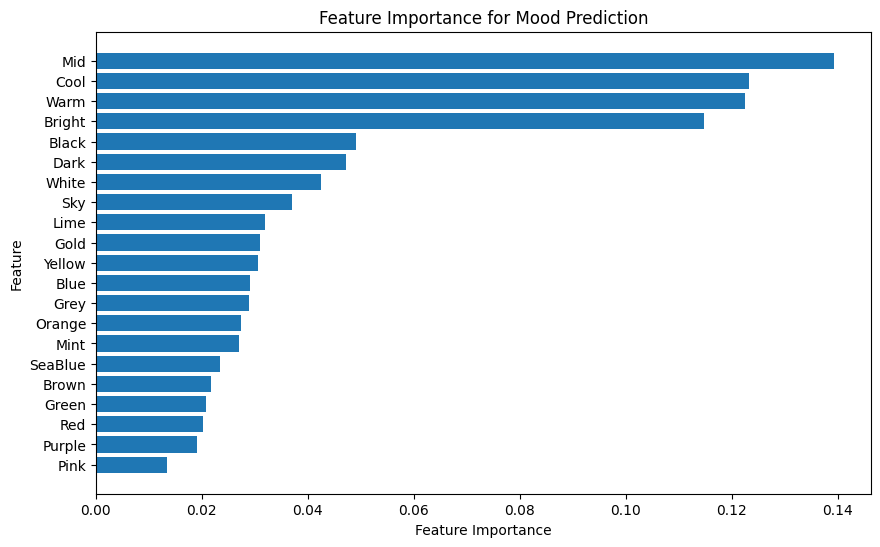

In [64]:
# 결과 시각화
import matplotlib.pyplot as plt

# 특성 중요도 추출
feature_importances = model.feature_importances_

# 특성 이름
feature_names = X.columns

# 중요도에 따라 특성 정렬
sorted_idx = feature_importances.argsort()

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], feature_importances[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Mood Prediction')
plt.show()


In [ ]:
# 파일분류
import pandas as pd
import os
import shutil

# 원본 이미지 폴더와 새로운 폴더 경로 정의
data = pd.read_csv("analysis_results.csv")
categorized_images = 'categorized_images'  # 분류된 이미지를 저장할 새 폴더 경로


# 각 이미지를 해당하는 폴더로 카피하는 로직 수행
for index, row in data.iterrows():
    # 분류 폴더명 생성 (Tone, DominantColor, Brightness를 기준으로)
    folder_name = f"{row['Mood']}"

    # 원본 파일 경로
    original_file_path = os.path.join(directory_path, row['Filename'])

    # 새 폴더 경로
    new_folder_path = os.path.join(categorized_images, folder_name)
    os.makedirs(new_folder_path, exist_ok=True)  # 폴더가 없으면 생성, 이미 있으면 무시

    # 이미지를 새 폴더로 카피
    csv_file_path = os.path.join(new_folder_path, row['Filename'])
    shutil.copy(original_file_path, csv_file_path)

In [ ]:
def determine_mood(row, rules):
    
    for mood, values in rules.items():
        if row['Tone'] == values[0] and row['DominantColor'] == values[1] and row['Brightness'] == values[2]:
            return mood
    return 'Undefined'  # 일치하는 분위기가 없는 경우

# 데이터셋의 각 행에 대해 분위기를 결정합니다.
data['Mood'] = data.apply(lambda row: determine_mood(row, music_mood_mapping), axis=1)